#**Credit Card Fraud Detection using ML**


Credit card fraud is one of those critical issues where quick and accurate detection can save both money and trust. As frauds are quite rare, detecting them becomes challenging but very important. In this project, I’ve worked on identifying such fraudulent transactions using anomaly detection techniques along with classification models. The idea is to help financial systems catch fraud before it causes damage.


## Content

The dataset used here includes credit card transactions made by European cardholders during just two days in September 2013. Out of a total of **284,807 transactions**, only **492 are fraudulent** — making it a classic case of **highly imbalanced data** (frauds make up just **0.172%** of the dataset).

Most of the features in the dataset are anonymized and transformed using **PCA** for privacy reasons. These are named `V1` to `V28`. Two features are left untouched:
- **`Time`**: seconds since the first transaction
- **`Amount`**: the transaction amount

The target variable is **`Class`**:
- `0` means normal transaction  
- `1` means fraudulent transaction

Due to the extreme class imbalance, traditional accuracy isn't very helpful. That’s why I focused more on **Precision**, **Recall**, **F1-score**, and especially the **AUC (Area Under the ROC Curve)** to judge model performance.


###**Importing Important Libraries**
We start by importing essential Python libraries for data handling (pandas), visualization (matplotlib, seaborn), and later, modeling.

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

###**Loading the dataset**
We load the credit card transaction dataset and preview its structure. The dataset contains 174,418 rows and 31 columns including the target variable Class.

In [44]:
df = pd.read_csv("creditcard.csv")

In [45]:
print("Shape of dataset:", df.shape)
print("Column names:", df.columns.tolist())

Shape of dataset: (284807, 31)
Column names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [46]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


###**Understand Class Distribution (Imbalance)**

In [47]:
# Count of each class
class_counts = df['Class'].value_counts()
print(class_counts)

Class
0    284315
1       492
Name: count, dtype: int64


The dataset is highly imbalanced — out of ~174k records, only 361 are fraudulent transactions.

/tmp/ipython-input-1208387294.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


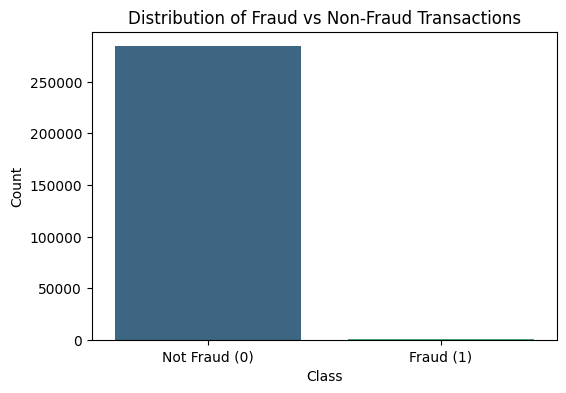

In [48]:
# Plot the class distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.ylabel('Count')
plt.show()

###**Preprocessing the Data**

#### Split X and Y
We separate the input features (X) from the target variable (Class) which indicates whether a transaction is fraudulent or not.

In [49]:
# Drop target column from features
X = df.drop('Class', axis=1)
y = df['Class']

#### Scale Amount and Time
 We standardize Amount and Time features to bring them to a similar scale. This helps certain ML models perform better

In [50]:
from sklearn.preprocessing import StandardScaler

# Copy so that the original data is not overwritten
X_scaled = X.copy()

scaler = StandardScaler()
X_scaled['Amount'] = scaler.fit_transform(X[['Amount']])
X_scaled['Time'] = scaler.fit_transform(X[['Time']])

In [51]:
# Check how many NaNs are in the target
print("NaNs in Class column:", df['Class'].isna().sum())

# Drop rows with NaN in Class (just to be safe)
df = df.dropna(subset=['Class'])

# Recreate X and y after drop
X = df.drop('Class', axis=1)
y = df['Class']

# Re-scale Amount and Time again
X_scaled = X.copy()
scaler = StandardScaler()
X_scaled['Amount'] = scaler.fit_transform(X[['Amount']])
X_scaled['Time'] = scaler.fit_transform(X[['Time']])

NaNs in Class column: 0


#### Train-Test Split
We split the data into training (70%) and testing (30%) sets using stratified sampling to maintain class balance.

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (199364, 30)
Test set shape: (85443, 30)


###**Use SMOTE from imbalanced-learn to fix class imbalance in training data.**
SMOTE is applied to the training data to generate synthetic samples of the minority class (fraud) to balance the dataset.


In [53]:
!pip install -q imbalanced-learn

from imblearn.over_sampling import SMOTE

In [54]:
# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Fit only on the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 199020, 1: 344})
After SMOTE: Counter({0: 199020, 1: 199020})


###**Train Classification Models**

#### **Logistic Regression**
We train a logistic regression model and evaluate it using confusion matrix, classification report, and AUC score.

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluation
print("Logistic Regression Results:-")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("AUC Score:", roc_auc_score(y_test, y_pred_lr))


Logistic Regression Results:-
[[83376  1919]
 [   18   130]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

AUC Score: 0.9279399952153339


 Logistic Regression has very high recall (88%) for fraud class but very low precision (6%), meaning it identifies almost all frauds but also misclassifies a large number of non-frauds as frauds (i.e., many false positives). Good AUC, but not practical for real-world deployment due to too many alerts.



#### **Random Forest Classifier**
We now train a Random Forest model which generally performs well on tabular datasets. We also calculate AUC using prediction probabilities.

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Results:-")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("AUC Score:", roc_auc_score(y_test, y_pred_rf))


Random Forest Results:-
[[85277    18]
 [   31   117]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.79      0.83       148

    accuracy                           1.00     85443
   macro avg       0.93      0.90      0.91     85443
weighted avg       1.00      1.00      1.00     85443

AUC Score: 0.8951647541204373


Much better balance between precision (87%) and recall (79%) than logistic regression. Random Forest gives a more trustworthy model for deployment.

#### Hyperparameter Tuning: Random Forest with Max Depth

In [57]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=12, n_jobs=-1, random_state=42)

#### Training Time Check

In [58]:
# Training time comparison
import time
start = time.time()
# model.fit(...)
end = time.time()
print(f"Training time: {end - start:.2f} seconds")

Training time: 0.00 seconds


#### Final Evaluation After Tuning

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.59      0.81      0.68       148

    accuracy                           1.00     85443
   macro avg       0.79      0.90      0.84     85443
weighted avg       1.00      1.00      1.00     85443

[[85210    85]
 [   28   120]]
ROC AUC Score: 0.9718178404678199


By reducing max_depth, we controlled overfitting a bit while still keeping strong performance. Slight trade-off in recall and precision compared to earlier RF model, but much better AUC (0.97). This version is more generalizable and practical.

###**ROC Curve Comparison**

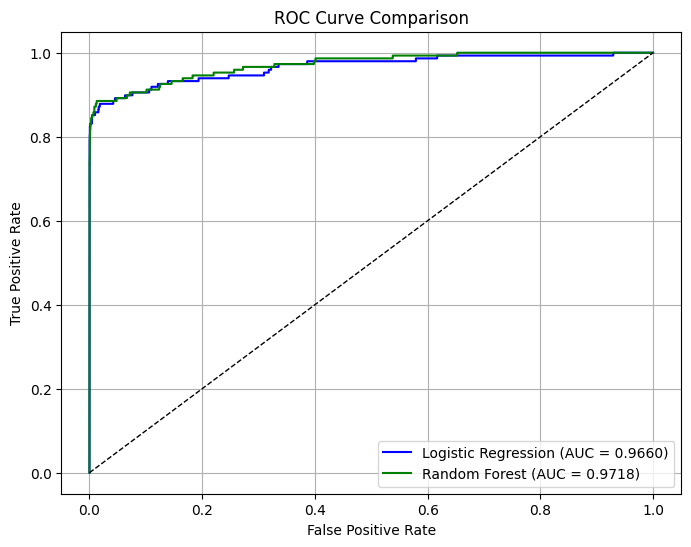

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute predicted probabilities
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curves and AUCs
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.4f})", color='blue')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


This plot helps us visually compare the performance of the two classifiers. Higher AUC = better distinction between classes.

###**Feature Importance Plot (for Random Forest)**

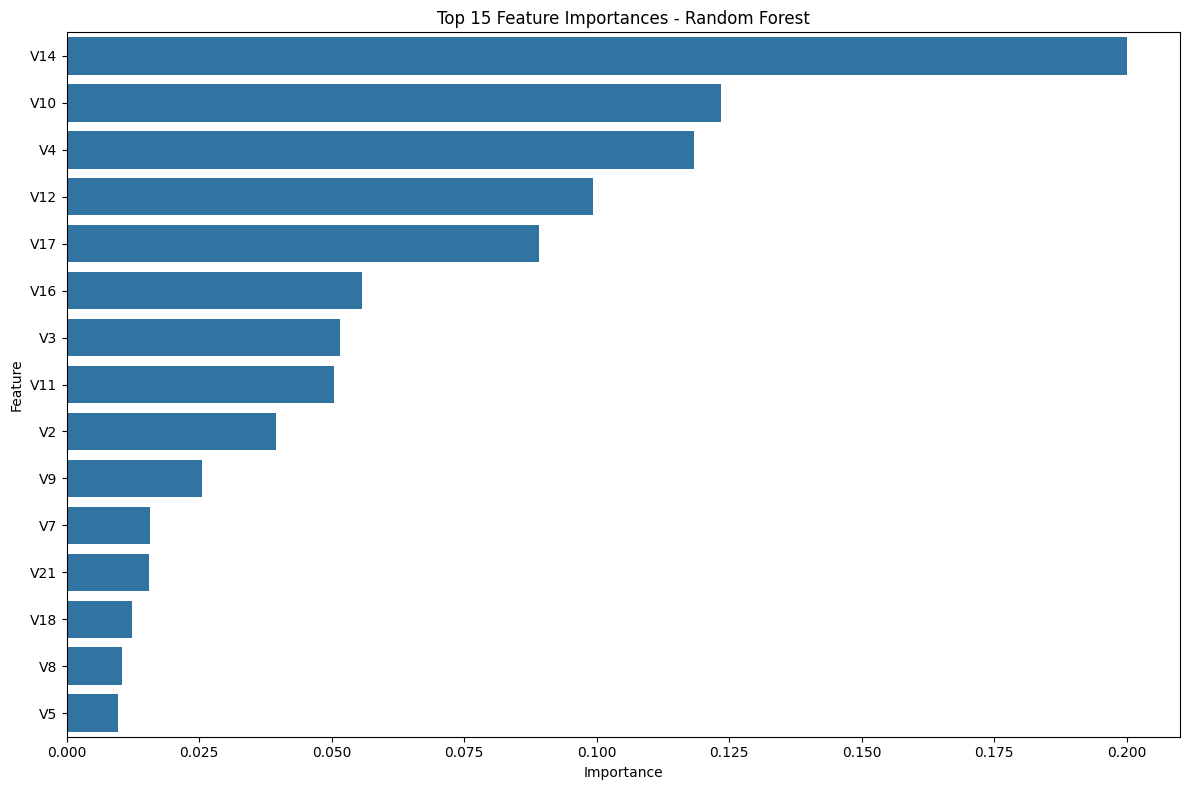

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_

# Use the correct variable name from SMOTE
feature_names = X_train_resampled.columns

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 15 important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


##**Summary of Results**

| Model                        | Precision (fraud) | Recall (fraud) | F1-score (fraud) | AUC     |
|-----------------------------|-------------------|----------------|------------------|---------|
| Logistic Regression         | 0.06              | 0.88           | 0.12             | 0.9279  |
| Random Forest (default)     | 0.87              | 0.79           | 0.83             | 0.8952  |
| Random Forest (max_depth=12)| 0.59              | 0.81           | 0.68             | 0.9718  |


This shows which features the Random Forest model considers most important in detecting fraud.

In this project, I successfully implemented a machine learning pipeline to detect credit card fraud.

Key steps included:
1.   Preprocessing the data
2.   Handling severe class imbalance using SMOTE
3.   Training and evaluating Logistic Regression and Random Forest models
4.   Comparing performance using ROC Curve and AUC Score
5.   Identifying key predictive features using Feature Importance



##**Final Observations**

After trying out different models on this highly imbalanced credit card fraud dataset, here are a few key takeaways:

- **Logistic Regression** showed very high recall for fraud cases but at the cost of very low precision. It ended up flagging many non-fraud cases as fraud. This might be useful if the goal is to catch *as many frauds as possible*, even if it means more false alarms.
  
- **Random Forest (default settings)** gave a strong overall performance, maintaining high precision and recall for fraud cases. It did better at not over-flagging normal transactions, making it more balanced for practical use.

- **Random Forest with tuning (`max_depth=12`)** struck a good trade-off. It performed slightly better in terms of AUC, and its F1-score for fraud detection was fairly balanced. It seems like a robust choice when we want both accuracy and reliability in identifying fraudulent transactions.

- Overall, **handling class imbalance** through techniques like oversampling or resampling made a significant difference in improving fraud detection. Also, relying only on accuracy would have been misleading — metrics like **AUC, precision, and recall** provided much deeper insight into model behavior.
